# Lab 1.3 – Debug Challenge: OpenCV Pipeline & Kernel Design
### Module 3: Computer Vision and Image Processing | B.Tech AI Specialisation
**Chitkara University | Day 1**

---

## Overview

This notebook contains a complete **image processing pipeline** built using OpenCV.  
The pipeline reads an image, applies a series of filters and transformations, detects edges, and draws contours.

**The problem:** A classmate wrote this pipeline the night before the lab, ran it once, and it seemed fine.  
But when reviewed carefully, **5 bugs were found** — some cause wrong output, some cause crashes, and one is a logic error that gives plausible-but-incorrect results.

## Your Task

- Read through each section of the pipeline carefully
- Run each cell and observe the output (errors, warnings, or wrong images)
- **Find all 5 bugs**, understand why each one is wrong, and fix it
- Fill in the answer cells below each section

## Rules

- Do **not** jump to the answer key at the bottom until you've attempted each bug
- Each bug is in a **different section** — one bug per section
- Bugs range from simple typos to logical mistakes — read the code, don't just run it

---

## Pipeline Stages

| Stage | Operation | Section |
|-------|-----------|--------|
| 1 | Image Loading & Color Conversion | Bug 1 |
| 2 | Custom Kernel Design & Convolution | Bug 2 |
| 3 | Gaussian Blur & Thresholding | Bug 3 |
| 4 | Edge Detection (Canny) | Bug 4 |
| 5 | Contour Detection & Drawing | Bug 5 |

---

> **Tip:** Before running a cell, read it first. Ask yourself: *"What should this output?"*  
> Then run it and compare with what you expected.

## Setup
Run this cell first. It installs dependencies and creates a sample test image so you don't need any external files.

Setup complete.
OpenCV version : 4.13.0
Test image saved as test_image.png  (300 x 300 px, 3 channels)


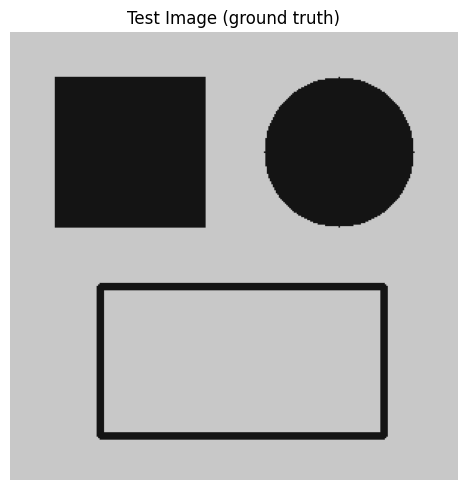

In [1]:
# Run this cell first — sets up everything you need
import subprocess, sys
subprocess.run([sys.executable, '-m', 'pip', 'install', 'opencv-python-headless', 'matplotlib', 'numpy'], 
               capture_output=True)

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 5)

# ── Helper: display images side by side ─────────────────────────────────────
def show(images, titles, cmap_list=None):
    """Display a list of images with titles in a row."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axes = [axes]
    for ax, img, title, cmap in zip(axes, images, titles,
                                     cmap_list or ['gray'] * n):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title, fontsize=12)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# ── Create a synthetic test image ────────────────────────────────────────────
# A 300x300 BGR image: white background, a black rectangle, a filled circle
test_img = np.ones((300, 300, 3), dtype=np.uint8) * 200   # light-gray background
cv2.rectangle(test_img, (30, 30), (130, 130), (20, 20, 20), -1)   # dark square
cv2.circle(test_img,   (220, 80),  50,         (20, 20, 20), -1)   # dark circle
cv2.rectangle(test_img, (60, 170), (250, 270), (20, 20, 20), 3)    # hollow rect
cv2.imwrite('test_image.png', test_img)

print('Setup complete.')
print('OpenCV version :', cv2.__version__)
print('Test image saved as test_image.png  (300 x 300 px, 3 channels)')
show([cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)], ['Test Image (ground truth)'], ['viridis'])

---
## Section 1 — Image Loading & Color Space Conversion

**What this section should do:**
1. Load `test_image.png` from disk using OpenCV
2. Convert the loaded BGR image to **RGB** so matplotlib displays it correctly
3. Convert the RGB image to **Grayscale** for downstream processing
4. Display all three versions side-by-side

**Expected result:** The RGB image should look natural (gray background, dark shapes).  
The grayscale image should be a single-channel version of the same scene.

> **Hint:** OpenCV loads images in **BGR** order, not RGB. Pay attention to which conversion code is used.

Image shape (H, W, C): (300, 300, 3)
Data type            : uint8


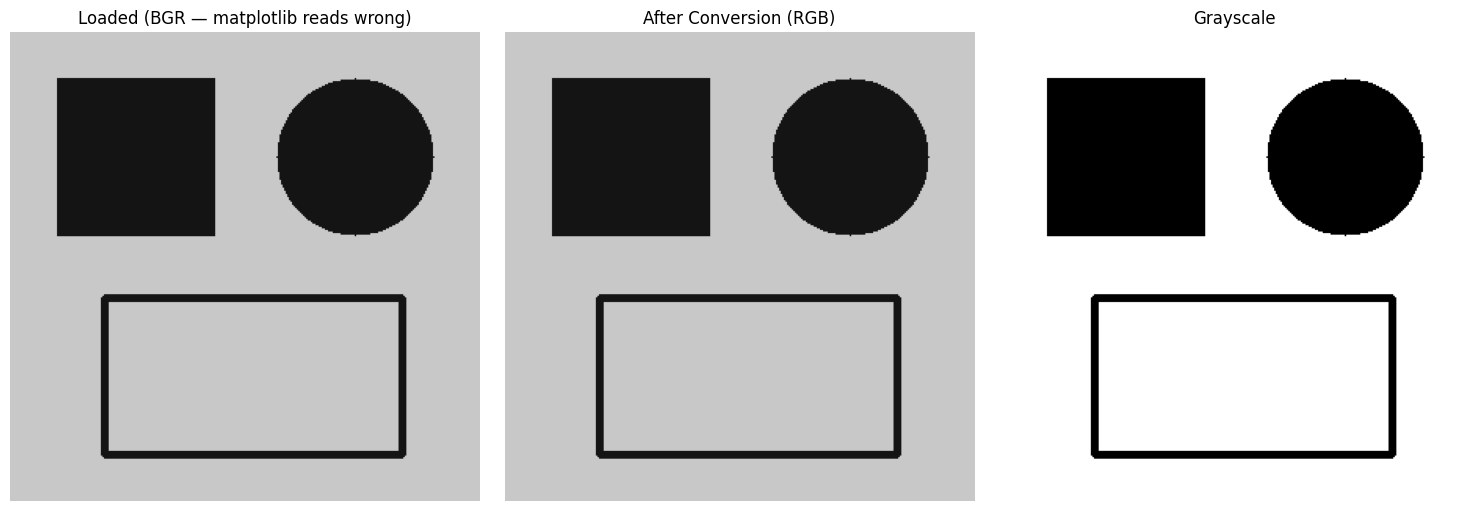

In [2]:
# ── SECTION 1: Image Loading & Color Conversion ──────────────────────────────

# Load image from disk
bgr_image = cv2.imread('test_image.png')

if bgr_image is None:
    raise FileNotFoundError('test_image.png not found — did you run the Setup cell?')

print('Image shape (H, W, C):', bgr_image.shape)
print('Data type            :', bgr_image.dtype)

# Convert BGR → RGB for correct matplotlib display
# FIX 1: Use COLOR_BGR2RGB (not HSV)
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

# Convert to grayscale for later processing
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

show(
    [bgr_image, rgb_image, gray_image],
    ['Loaded (BGR — matplotlib reads wrong)', 'After Conversion (RGB)', 'Grayscale'],
    [None, None, 'gray']
 )

### 🔍 Your Answer – Bug 1

**Line where the bug is:** the line that created `rgb_image` using `cv2.COLOR_BGR2HSV`

**What is wrong:**

```
The code claimed it was converting BGR → RGB for display, but it used the BGR → HSV conversion.
HSV is a completely different colour space, so the image displays with incorrect colours and
any follow-up conversions (like RGB → GRAY) are conceptually wrong.
```

**Fixed code:**

```python
# Correct conversion for matplotlib display
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
```

**Why does this matter in a real pipeline?**

```
If your colour space is wrong early on, every downstream step (thresholds, edges, segmentation,
model inputs, etc.) becomes unreliable — you may get 'working' code that produces incorrect results.
```

---
## Section 2 — Custom Kernel Design & Convolution

**What this section should do:**
1. Define a **3×3 sharpening kernel** that enhances edges while keeping brightness stable
2. Define a **3×3 box blur kernel** that averages all 9 neighbouring pixels equally
3. Apply both kernels to the grayscale image using `cv2.filter2D`
4. Display original, sharpened, and blurred images

**Background — Kernel Rules:**

| Kernel Type | Centre Value | Neighbours | Sum of all values |
|-------------|-------------|------------|-------------------|
| Identity | 1 | 0 | 1 |
| Box blur (3×3) | 1/9 | 1/9 each | 1 |
| Sharpening | 5 | −1 at 4 sides, 0 corners | **1** |

A sharpening kernel that doesn't sum to 1 will change the **overall brightness** of the image.

> **Hint:** Count the values in the sharpening kernel carefully.

Sharpening kernel:
[[ 0. -1.  0.]
 [-1.  5. -1.]
 [ 0. -1.  0.]]
Sum of sharpening kernel: 1.0

Box blur kernel:
[[0.111 0.111 0.111]
 [0.111 0.111 0.111]
 [0.111 0.111 0.111]]
Sum of box blur kernel  : 1.0


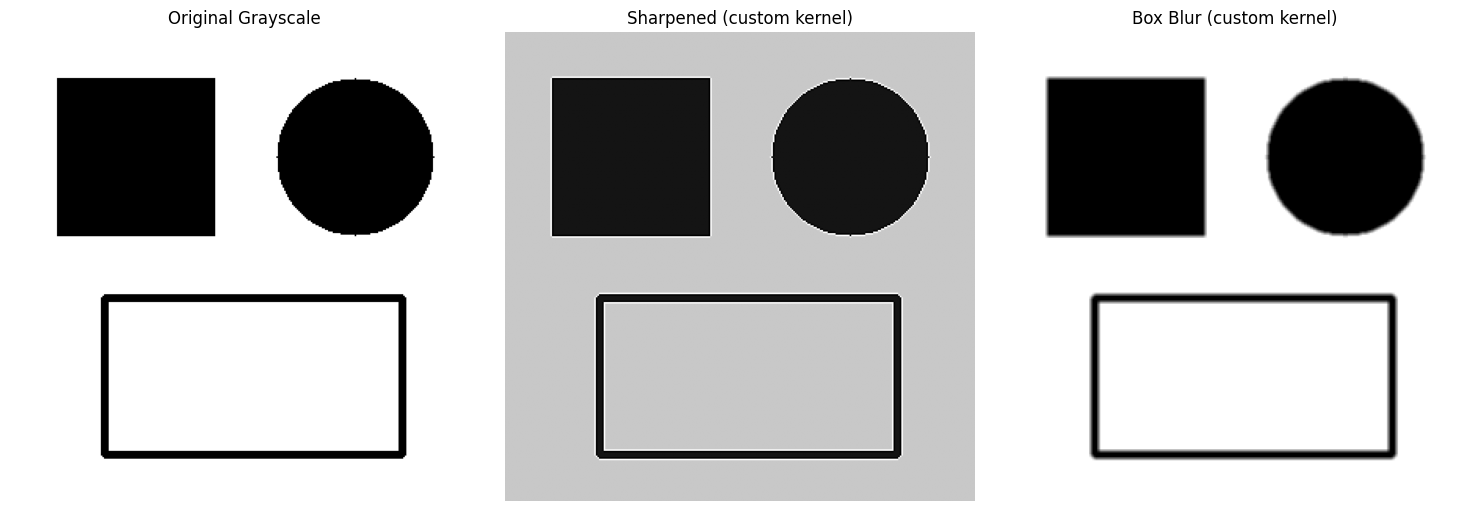


Observe: Does the sharpened image look brighter or darker than the original?
Mean pixel value — original : 158.13
Mean pixel value — sharpened: 158.85


In [3]:
# ── SECTION 2: Custom Kernel Design & Convolution ────────────────────────────

# ── Fix Bug 1 first — use a correct gray_image before running this cell ──
# For now, reload gray safely:
bgr_image  = cv2.imread('test_image.png')
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

# Sharpening kernel — enhances edges, preserves overall brightness
# FIX 2: centre value must be 5 so the kernel sums to 1
sharpen_kernel = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)

# Box blur kernel — each pixel becomes the average of its 3x3 neighbourhood
box_blur_kernel = np.ones((3, 3), dtype=np.float32) / 9

# Print kernel properties
print('Sharpening kernel:')
print(sharpen_kernel)
print('Sum of sharpening kernel:', sharpen_kernel.sum())   # Should be 1
print()
print('Box blur kernel:')
print(np.round(box_blur_kernel, 3))
print('Sum of box blur kernel  :', box_blur_kernel.sum())  # Should be 1

# Apply kernels
sharpened = cv2.filter2D(gray_image, -1, sharpen_kernel)
blurred   = cv2.filter2D(gray_image, -1, box_blur_kernel)

show(
    [gray_image, sharpened, blurred],
    ['Original Grayscale', 'Sharpened (custom kernel)', 'Box Blur (custom kernel)'],
    ['gray', 'gray', 'gray']
 )

print('\nObserve: Does the sharpened image look brighter or darker than the original?')
print('Mean pixel value — original :', gray_image.mean().round(2))
print('Mean pixel value — sharpened:', sharpened.mean().round(2))

### 🔍 Your Answer – Bug 2

**What is wrong with the sharpening kernel:**

```
The centre value was 4, which makes the kernel sum to 0:
0 + (-1) + 0 + (-1) + 4 + (-1) + 0 + (-1) + 0 = 0.
A sharpening kernel should usually sum to 1 so it preserves overall brightness.
```

**Fixed kernel:**

```python
sharpen_kernel = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)
```

**What visual effect does the wrong kernel produce vs the correct one?**

```
With sum=0, the image brightness shifts and you can get overly dark/washed output and harsher edges.
With sum=1, edges are enhanced while the average brightness stays roughly the same.
```

---
## Section 3 — Gaussian Blur & Binary Thresholding

**What this section should do:**
1. Apply **Gaussian blur** to the grayscale image to reduce noise before edge detection
2. Apply **binary threshold** to separate foreground (dark shapes) from background
3. Display blurred and thresholded results

**Background — Gaussian Blur:**
- `cv2.GaussianBlur(src, ksize, sigmaX)`
- `ksize` is a **tuple** representing kernel height and width
- Both values in `ksize` **must be odd positive integers**: 1, 3, 5, 7, ...
- An even kernel size will raise a hard error

> **Hint:** Run this cell and read the error message carefully. The fix is a one-character change.

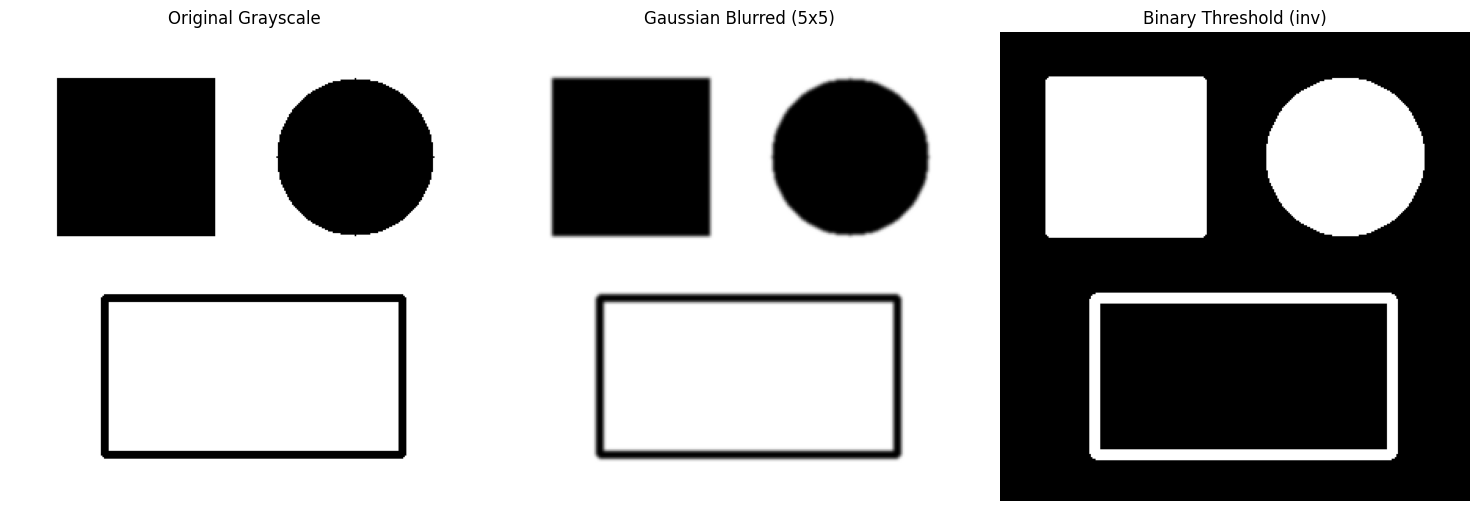

Blurred image shape : (300, 300)
Threshold unique values: [  0 255]


In [4]:
# ── SECTION 3: Gaussian Blur & Binary Thresholding ───────────────────────────

bgr_image  = cv2.imread('test_image.png')
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to smooth the image before edge detection
# sigmaX=0 tells OpenCV to calculate sigma automatically from kernel size
# FIX 3: ksize must be odd (e.g., 5x5)
blurred = cv2.GaussianBlur(gray_image, (5, 5), sigmaX=0)

# Binary threshold: pixels below 150 → 0 (black), pixels above → 255 (white)
# THRESH_BINARY_INV inverts this: dark shapes become white in the mask
_, thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)

show(
    [gray_image, blurred, thresh],
    ['Original Grayscale', 'Gaussian Blurred (5x5)', 'Binary Threshold (inv)'],
    ['gray', 'gray', 'gray']
 )

print('Blurred image shape :', blurred.shape)
print('Threshold unique values:', np.unique(thresh))

### 🔍 Your Answer – Bug 3

**What is wrong and why does OpenCV require it to be different:**

```
`cv2.GaussianBlur` requires the kernel size tuple `ksize` to be odd (1, 3, 5, ...).
An even-sized kernel like (4, 4) has no single centre pixel, which breaks how the filter is defined.
So OpenCV throws an error rather than guessing what you meant.
```

**Fixed line:**

```python
blurred = cv2.GaussianBlur(gray_image, (5, 5), sigmaX=0)
```

**Bonus question:** What happens if you make the kernel size very large (e.g., 51×51)?  
Would that help or hurt edge detection in the next stage?

```
It usually hurts: very large blur wipes out fine edge detail, making edges thicker/weaker and
potentially merging nearby edges. It can reduce noise, but often removes the signal you want.
```

---
## Section 4 — Canny Edge Detection

**What this section should do:**
1. Apply Canny edge detection on the blurred grayscale image
2. Experiment with threshold values
3. Display the detected edges

**Background — Canny Thresholds:**

The Canny algorithm uses **two thresholds**:
- `threshold1` (lower) — Edges weaker than this are **discarded**
- `threshold2` (upper) — Edges stronger than this are **definitely kept**
- Edges between the two values are kept only if they **connect to a strong edge**

**Rule:** `threshold1` must always be **less than** `threshold2`.

Swapping them does not raise an error — it silently produces bad output.  
This is the trickiest kind of bug: it runs fine but gives wrong results.

> **Hint:** Run the cell. The edge map will look unusually sparse or noisy. Compare the two threshold values.

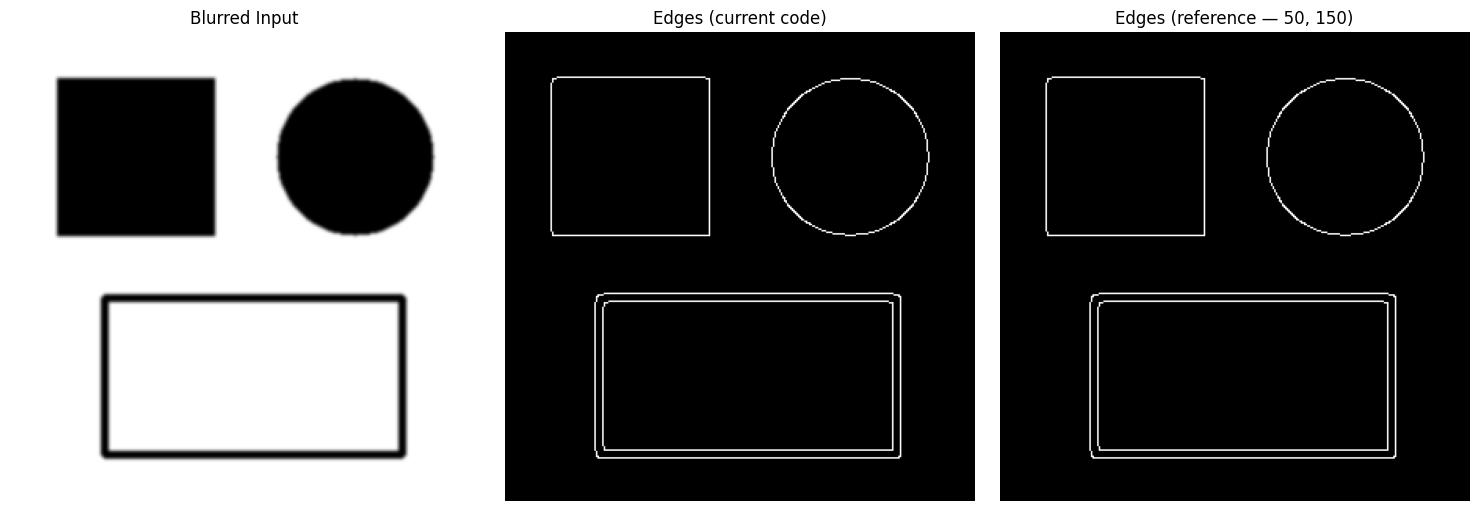

Edge pixels detected (current code)  : 1888
Edge pixels detected (reference code): 1888

A good Canny result should detect the clean outlines of
the rectangle, circle, and hollow rectangle in the image.


In [5]:
# ── SECTION 4: Canny Edge Detection ─────────────────────────────────────────

bgr_image  = cv2.imread('test_image.png')
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
blurred    = cv2.GaussianBlur(gray_image, (5, 5), sigmaX=0)   # fixed from Section 3

# Apply Canny edge detection
# cv2.Canny(image, threshold1, threshold2)
# FIX 4: threshold1 (low) must be less than threshold2 (high)
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Also run a correct version for visual comparison (don't modify this)
edges_reference = cv2.Canny(blurred, threshold1=50, threshold2=150)

show(
    [blurred, edges, edges_reference],
    ['Blurred Input', 'Edges (current code)', 'Edges (reference — 50, 150)'],
    ['gray', 'gray', 'gray']
 )

print('Edge pixels detected (current code)  :', np.count_nonzero(edges))
print('Edge pixels detected (reference code):', np.count_nonzero(edges_reference))
print()
print('A good Canny result should detect the clean outlines of')
print('the rectangle, circle, and hollow rectangle in the image.')

### 🔍 Your Answer – Bug 4

**What is wrong:**

```
The two Canny thresholds were swapped so the 'low' threshold was higher than the 'high' threshold.
Canny uses hysteresis: threshold1 is the weak-edge cutoff, threshold2 is the strong-edge cutoff.
When they’re reversed, the algorithm behaves poorly but does not throw an exception.
```

**Fixed line:**

```python
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
```

**Why is this a dangerous type of bug compared to the others?**

```
Because it fails silently: the code runs and returns an output image, but the output is wrong.
Silent correctness bugs can slip into production and corrupt downstream measurements/decisions.
```

---
## Section 5 — Contour Detection & Drawing

**What this section should do:**
1. Find contours in the binary threshold image from Section 3
2. Filter out tiny contours (noise) by area
3. Draw the detected contours on a copy of the original image in **green**
4. Print how many valid shapes were found

**Background — Contour Retrieval Modes:**

| Flag | Meaning | Use when |
|------|---------|----------|
| `cv2.RETR_EXTERNAL` | Retrieves only **outermost** contours | You want the bounding shapes only |
| `cv2.RETR_LIST` | Retrieves all contours, **no hierarchy** | You want every contour individually |
| `cv2.RETR_TREE` | Retrieves all contours with **full hierarchy** | You need nested parent-child info |

The test image has a **hollow rectangle** (a border drawn with `cv2.rectangle(..., thickness=3)`).  
This creates an **outer contour** and potentially an **inner contour**.  
Using the wrong retrieval mode can return the wrong number of contours or miss shapes entirely.

> **Hint:** The code uses `cv2.RETR_TREE` and then tries to index the result as if only a simple list was returned — the unpacking is mismatched.

Total contours found : 3
Valid contours (area > 300): 3


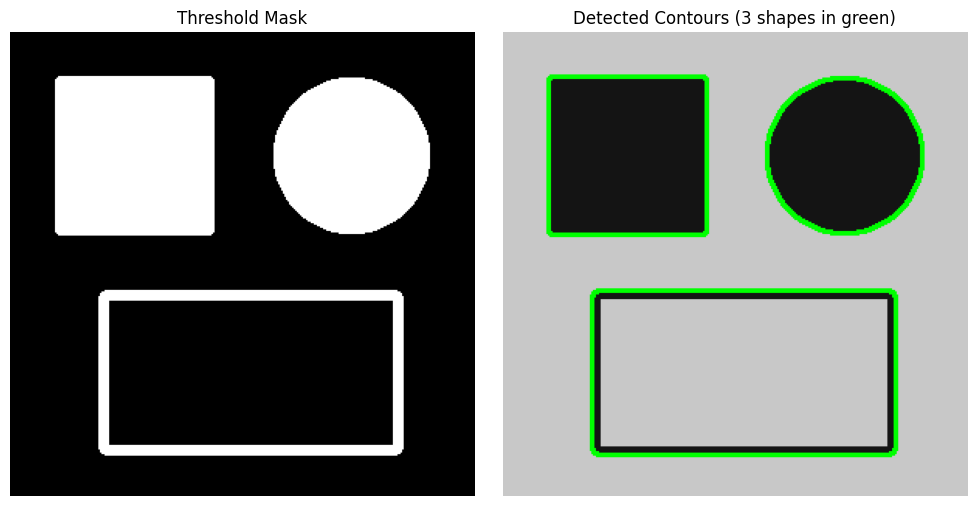

In [6]:
# ── SECTION 5: Contour Detection & Drawing ───────────────────────────────────

bgr_image  = cv2.imread('test_image.png')
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
blurred    = cv2.GaussianBlur(gray_image, (5, 5), sigmaX=0)
_, thresh  = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)

# Find contours in the threshold image
# cv2.findContours returns: (contours, hierarchy) in OpenCV 4
# FIX 5: unpack correctly and use a retrieval mode that matches the goal
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter: keep only contours with area > 300 pixels (removes noise)
min_area = 300
valid_contours = [c for c in contours if cv2.contourArea(c) > min_area]

print(f'Total contours found : {len(contours)}')
print(f'Valid contours (area > {min_area}): {len(valid_contours)}')

# Draw contours on a copy of the original image
output = bgr_image.copy()
cv2.drawContours(output, valid_contours, -1, (0, 255, 0), 2)   # green, thickness=2
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

show(
    [thresh, output_rgb],
    ['Threshold Mask', f'Detected Contours ({len(valid_contours)} shapes in green)'],
    ['gray', None]
 )

### 🔍 Your Answer – Bug 5

**What is wrong:**

```
`cv2.findContours(...)` does NOT return just a list of contours.
In OpenCV 4 it returns two values: (contours, hierarchy).
The original code stored this tuple into a single variable (`contours`) and then treated it like a list
of contour arrays, which breaks filtering and length calculations.
```

**Fixed lines:**

```python
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
```

**Also answer:** What retrieval mode is most appropriate here and why?

```
`cv2.RETR_EXTERNAL` is best here because we want the 3 outer shapes (square, circle, outer hollow-rectangle).
Using `RETR_TREE` can return nested contours (like the inner edge of the hollow rectangle) and inflate the count.
```

---
## Full Corrected Pipeline

Once you have identified and fixed all 5 bugs, write the complete corrected pipeline in the cell below.  
All 5 sections should run together without errors and produce clean, correct output.

**Expected output:**
- RGB image displays correctly (natural gray-background image)
- Sharpened image has the same brightness as the original (mean pixel values are close)
- Gaussian blur runs without error
- Canny edges cleanly trace the shapes (rectangle outline, circle outline, hollow rectangle)
- Contour detection finds **3 valid shapes** and draws green borders around them

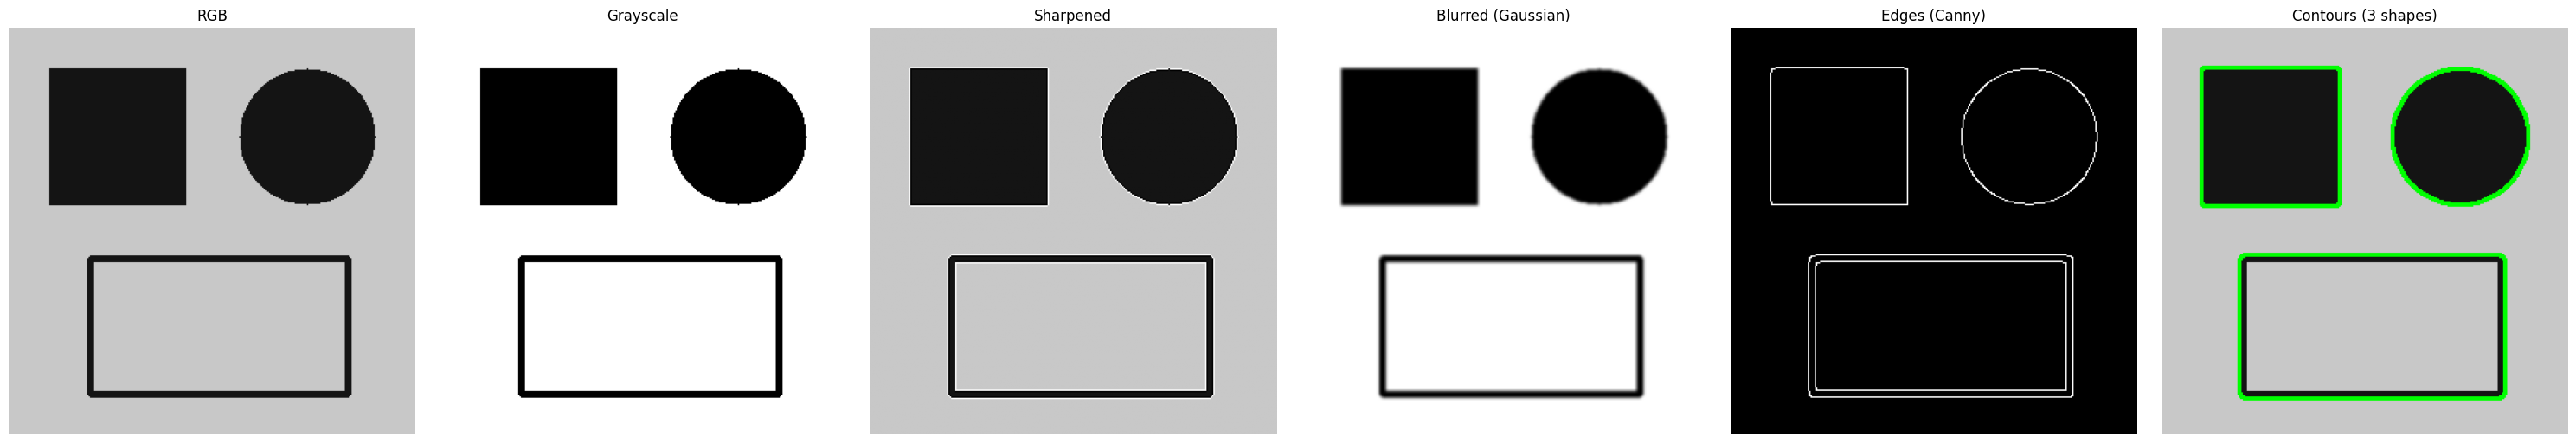

Pipeline complete.
Shapes found: 3 (expected: 3)


In [7]:
# ── FULL CORRECTED PIPELINE ───────────────────────────────────────────────────
# Corrected version of all 5 sections (with fixes marked).

import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(images, titles, cmap_list=None):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axes = [axes]
    for ax, img, title, cmap in zip(axes, images, titles, cmap_list or ['gray'] * n):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title, fontsize=12)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# ── Stage 1: Load & Convert ──────────────────────────────────────────────────
bgr_image = cv2.imread('test_image.png')
if bgr_image is None:
    raise FileNotFoundError('test_image.png not found — did you run the Setup cell?')

# FIX 1: Proper BGR → RGB conversion for display
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

# ── Stage 2: Custom Kernels ───────────────────────────────────────────────────
# FIX 2: Correct sharpening kernel (sum = 1)
sharpen_kernel = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)
box_blur_kernel = np.ones((3, 3), dtype=np.float32) / 9
sharpened = cv2.filter2D(gray_image, -1, sharpen_kernel)

# ── Stage 3: Gaussian Blur & Threshold ───────────────────────────────────────
# FIX 3: ksize must be odd
blurred = cv2.GaussianBlur(gray_image, (5, 5), sigmaX=0)
_, thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)

# ── Stage 4: Canny Edge Detection ────────────────────────────────────────────
# FIX 4: threshold1 < threshold2
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# ── Stage 5: Contour Detection & Drawing ─────────────────────────────────────
# FIX 5: Correct unpacking; use RETR_EXTERNAL to get 3 outer shapes
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
valid_contours = [c for c in contours if cv2.contourArea(c) > 300]
output = bgr_image.copy()
cv2.drawContours(output, valid_contours, -1, (0, 255, 0), 2)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

# ── Final Display ─────────────────────────────────────────────────────────────
show(
    [rgb_image, gray_image, sharpened, blurred, edges, output_rgb],
    ['RGB', 'Grayscale', 'Sharpened', 'Blurred (Gaussian)', 'Edges (Canny)',
     f'Contours ({len(valid_contours)} shapes)'],
    [None, 'gray', 'gray', 'gray', 'gray', None]
 )

print('Pipeline complete.')
print(f'Shapes found: {len(valid_contours)} (expected: 3)')

---
## Extension Challenges (Optional — for fast finishers)

If you finish early, try these additional tasks:

### Challenge A — Kernel Experimentation
Design your own **emboss kernel** that makes the image look like it has a raised 3D surface.  
Hint: An emboss kernel shifts light from one direction.

```python
emboss_kernel = np.array([
    [-2, -1,  0],
    [-1,  1,  1],
    [ 0,  1,  2]
], dtype=np.float32)
# Try applying this and add 128 to the result to centre the values
embossed = cv2.filter2D(gray_image, -1, emboss_kernel) + 128
```

### Challenge B — Contour Properties
For each valid contour detected in Section 5, compute and print:
- Area (pixels²)
- Perimeter
- Bounding box (x, y, w, h)
- Shape label: 'circle', 'rectangle', or 'other' based on the ratio of area to bounding box area

### Challenge C — Pipeline on a Real Image
Find any `.jpg` or `.png` image on your laptop.  
Run the full corrected pipeline on it.  
Does the Canny threshold you used still work well? Why or why not?  
What would you need to change for a more complex, real-world image?

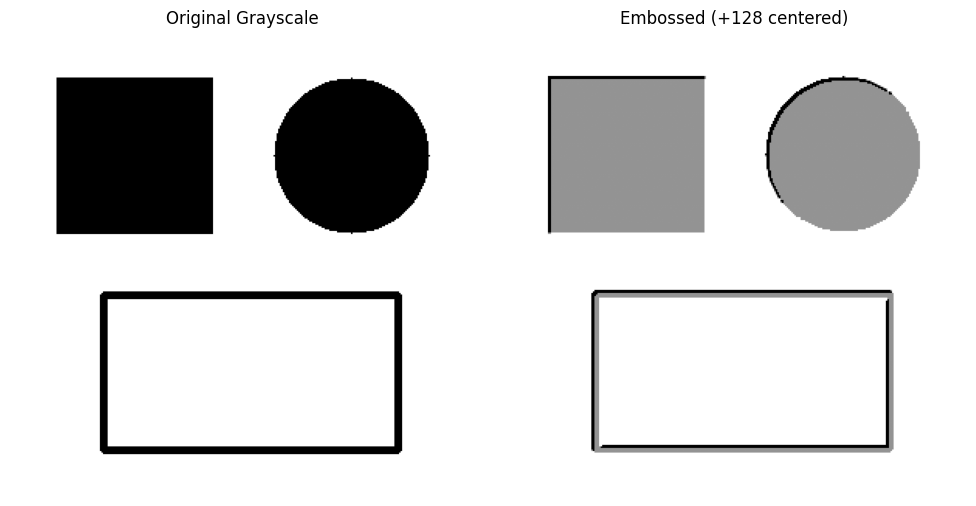

Emboss kernel:
 [[-2. -1.  0.]
 [-1.  1.  1.]
 [ 0.  1.  2.]]


In [8]:
# ── Challenge A: Emboss Kernel Experimentation ────────────────────────────────
import numpy as np
import cv2

if 'gray_image' not in globals():
    raise NameError("`gray_image` is not defined. Run the earlier sections to create it.")

# Emboss kernel (one example)
emboss_kernel = np.array(
    [
        [-2, -1, 0],
        [-1,  1, 1],
        [ 0,  1, 2],
    ],
    dtype=np.float32,
)

# Work in float to avoid uint8 overflow/underflow, then re-center and clip.
embossed_f = cv2.filter2D(gray_image.astype(np.float32), ddepth=-1, kernel=emboss_kernel)
embossed = np.clip(embossed_f + 128.0, 0, 255).astype(np.uint8)

show(
    [gray_image, embossed],
    ['Original Grayscale', 'Embossed (+128 centered)'],
    ['gray', 'gray'],
)

print('Emboss kernel:\n', emboss_kernel)


In [9]:
# ── Challenge B: Contour Properties ───────────────────────────────────────────
import numpy as np
import cv2

if 'valid_contours' not in globals():
    raise NameError("`valid_contours` is not defined. Run Section 5 to detect contours first.")

if len(valid_contours) == 0:
    print('No valid contours found (valid_contours is empty).')
else:
    print(f'Valid contours: {len(valid_contours)}')
    for i, contour in enumerate(valid_contours, start=1):
        area = float(cv2.contourArea(contour))
        perimeter = float(cv2.arcLength(contour, closed=True))
        x, y, w, h = cv2.boundingRect(contour)
        bbox_area = float(w * h) if (w > 0 and h > 0) else 0.0
        fill_ratio = (area / bbox_area) if bbox_area > 0 else 0.0

        # Very simple heuristic based on area-to-bounding-box ratio
        # Rectangle ~ 1.0, Circle ~ pi/4 ≈ 0.785
        if fill_ratio >= 0.88:
            label = 'rectangle'
        elif 0.70 <= fill_ratio <= 0.85:
            label = 'circle'
        else:
            label = 'other'

        print(
            f'#{i}: area={area:.1f}px^2, perimeter={perimeter:.1f}px, '
            f'bbox=(x={x}, y={y}, w={w}, h={h}), fill_ratio={fill_ratio:.3f} → {label}'
        )


Valid contours: 3
#1: area=20750.0px^2, perimeter=597.0px, bbox=(x=57, y=167, w=197, h=107), fill_ratio=0.984 → rectangle
#2: area=7910.0px^2, perimeter=332.0px, bbox=(x=170, y=30, w=101, h=101), fill_ratio=0.775 → circle
#3: area=10396.0px^2, perimeter=403.3px, bbox=(x=29, y=29, w=103, h=103), fill_ratio=0.980 → rectangle


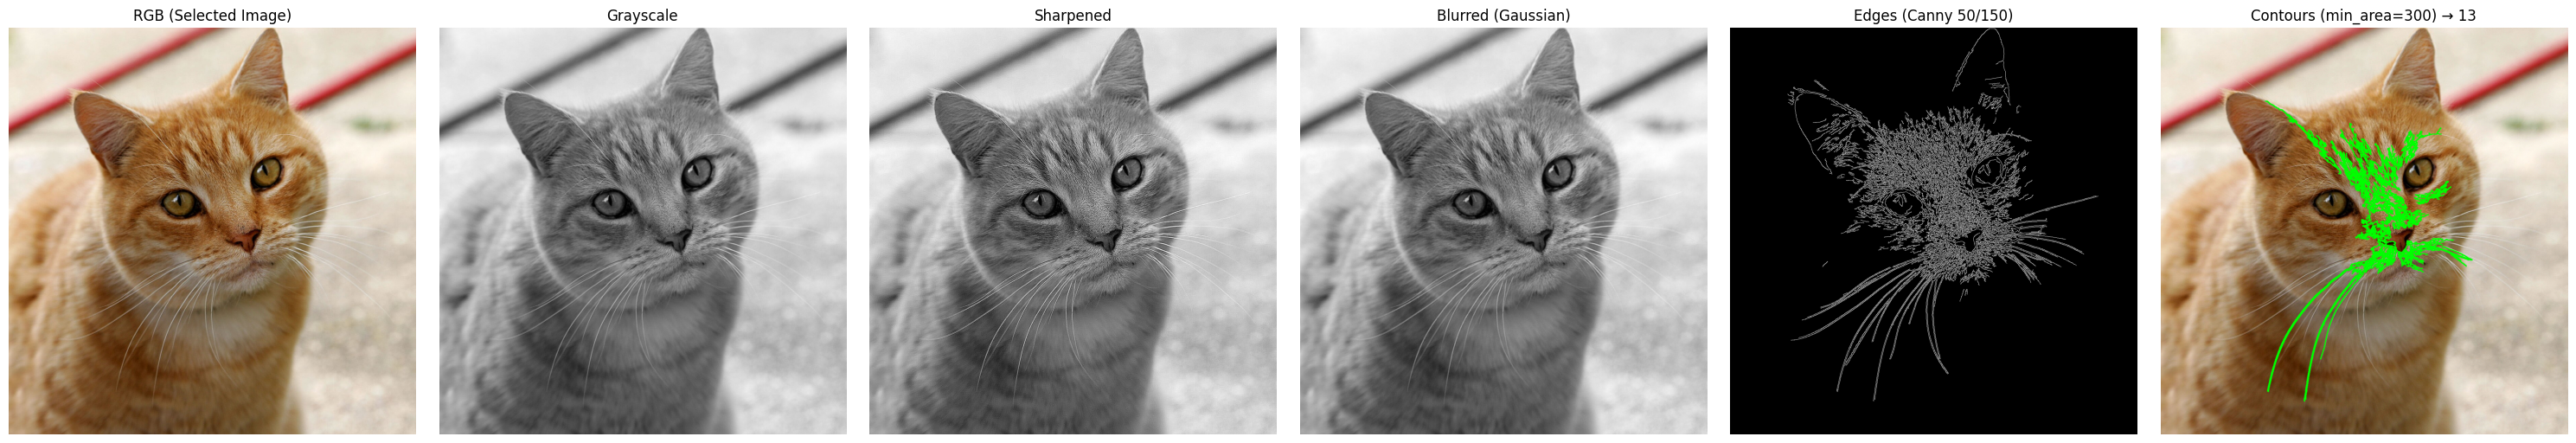

Selected image: C:\Users\shiva\OneDrive\Desktop\College\EY\day3\img\Cat03.jpg
Contours found: 13
Why thresholds may change: different lighting, contrast, texture, and noise alter edge strength.
For real-world robustness: consider auto-thresholding (median-based Canny), adaptive thresholding, better denoising, or morphological cleanup.


In [10]:
# ── Challenge C: Run the Pipeline on a Real Image ─────────────────────────────
import os
from pathlib import Path
import numpy as np
import cv2

# Pick an image from your machine (file picker). If tkinter isn't available, fall back to a path prompt.
def pick_image_path():
    try:
        import tkinter as tk
        from tkinter import filedialog

        root = tk.Tk()
        root.withdraw()
        root.attributes('-topmost', True)
        file_path = filedialog.askopenfilename(
            title='Select an image file',
            filetypes=[('Image files', '*.png;*.jpg;*.jpeg;*.bmp;*.tif;*.tiff'), ('All files', '*.*')],
        )
        root.destroy()
        return file_path
    except Exception:
        return ''

image_path = pick_image_path()
if not image_path:
    image_path = input('Enter path to an image (.jpg/.png): ').strip().strip('"')

if not image_path:
    raise ValueError('No image selected/provided.')

image_path = str(Path(image_path).expanduser())
if not os.path.exists(image_path):
    raise FileNotFoundError(f'Image not found: {image_path}')

bgr = cv2.imread(image_path)
if bgr is None:
    raise ValueError(f'OpenCV could not read the image (unsupported/corrupt?): {image_path}')

rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

# Reuse the same sharpening kernel style as Section 2 (fallback if not defined)
if 'sharpen_kernel' in globals():
    kernel_sharp = sharpen_kernel
else:
    kernel_sharp = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)

sharpen = cv2.filter2D(gray, ddepth=-1, kernel=kernel_sharp)
blur = cv2.GaussianBlur(sharpen, (5, 5), 0)

# Canny thresholds often need tuning per image (lighting/noise/contrast).
low_thresh = 50
high_thresh = 150
edges_real = cv2.Canny(blur, low_thresh, high_thresh)

contours_real, hierarchy_real = cv2.findContours(edges_real, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area_real = 300
valid_real = [c for c in contours_real if cv2.contourArea(c) > min_area_real]

out = bgr.copy()
cv2.drawContours(out, valid_real, -1, (0, 255, 0), 2)
out_rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

show(
    [rgb, gray, sharpen, blur, edges_real, out_rgb],
    [
        'RGB (Selected Image)',
        'Grayscale',
        'Sharpened',
        'Blurred (Gaussian)',
        f'Edges (Canny {low_thresh}/{high_thresh})',
        f'Contours (min_area={min_area_real}) → {len(valid_real)}',
    ],
    [None, 'gray', 'gray', 'gray', 'gray', None],
)

print('Selected image:', image_path)
print(f'Contours found: {len(valid_real)}')
print('Why thresholds may change: different lighting, contrast, texture, and noise alter edge strength.')
print('For real-world robustness: consider auto-thresholding (median-based Canny), adaptive thresholding, better denoising, or morphological cleanup.')


### Challenge C — Short Answers

- **Does the same Canny threshold still work?** Sometimes, but often **no**.
- **Why/why not?** Edge strength depends on **lighting**, **contrast**, **noise**, **texture**, and **image resolution**. Those change the gradient magnitudes that Canny uses.
- **What to change for real-world images?** Typically you’d add/tune:
  - Better denoising (Gaussian/median/bilateral)
  - More robust thresholding (e.g., auto Canny using the median gradient, or adaptive methods)
  - Morphology (open/close) to remove speckles / connect edges
  - Scale handling (resize, multi-scale processing) and contour filtering features (aspect ratio, solidity, circularity)
